In [368]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


In [369]:
class Dolphin:
    def __init__(self, name: str, gender: str):
        self.name = name
        self.gender = gender

    def __str__(self):
        return f'Name: {self.name:<15} | Gender: {self.gender}'

In [370]:
# Build a dolphin dictionary
dolphins: list[Dolphin] = []
with open('data/dolphininfo.txt', 'r') as f:
    for idx, line in enumerate(f):
        name, gender = line.strip().split()
        new_dolphin = Dolphin(name,gender)
        dolphins.append(new_dolphin)

for i in range(5):
    print(dolphins[i])

Name: Beak            | Gender: M
Name: Beescratch      | Gender: M
Name: Bumper          | Gender: M
Name: CCL             | Gender: F
Name: Cross           | Gender: M


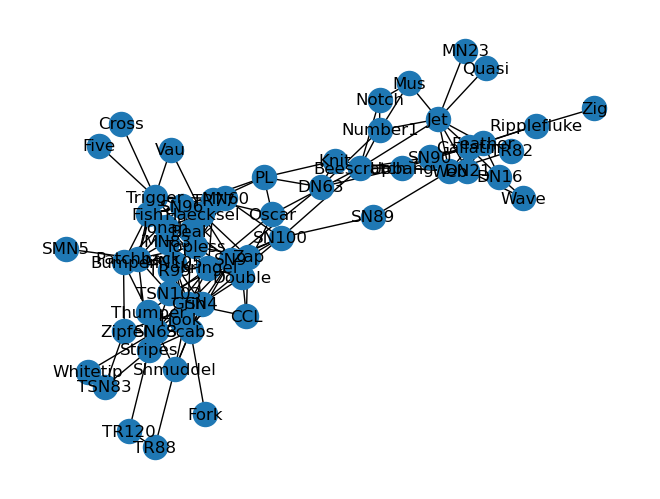

In [371]:
# Build a dolphines network
dolphin_graph = nx.Graph()

with open('data/dolphins.txt', 'r') as f:
    lines = f.readlines()
    
    no_nodes = int(lines[0])
    dolphin_graph.add_nodes_from([dolphins[i].name for i in range(no_nodes)])

    # dolphin_graph.add_edges_from([tuple(map(int, line.split())) for line in lines[1:]])
    for line in lines[1:]:
        startpoint, endpoint = map(lambda x: int(x)-1, line.split())
        dolphin_graph.add_edge(dolphins[startpoint].name, dolphins[endpoint].name)

# Draw the network
nx.draw(dolphin_graph, with_labels=True)


In [372]:
d = {}
for node in dolphin_graph.nodes:
    d[node] = dolphin_graph.degree(node)

print(d)

{'Beak': 6, 'Beescratch': 8, 'Bumper': 4, 'CCL': 3, 'Cross': 1, 'DN16': 4, 'DN21': 6, 'DN63': 5, 'Double': 6, 'Feather': 7, 'Fish': 5, 'Five': 1, 'Fork': 1, 'Gallatin': 8, 'Grin': 12, 'Haecksel': 7, 'Hook': 6, 'Jet': 9, 'Jonah': 7, 'Knit': 4, 'Kringel': 9, 'MN105': 6, 'MN23': 1, 'MN60': 3, 'MN83': 6, 'Mus': 3, 'Notch': 3, 'Number1': 5, 'Oscar': 5, 'Patchback': 9, 'PL': 5, 'Quasi': 1, 'Ripplefluke': 3, 'Scabs': 10, 'Shmuddel': 5, 'SMN5': 1, 'SN100': 7, 'SN4': 11, 'SN63': 8, 'SN89': 2, 'SN9': 8, 'SN90': 5, 'SN96': 6, 'Stripes': 7, 'Thumper': 4, 'Topless': 11, 'TR120': 2, 'TR77': 6, 'TR82': 1, 'TR88': 2, 'TR99': 7, 'Trigger': 10, 'TSN103': 4, 'TSN83': 2, 'Upbang': 7, 'Vau': 2, 'Wave': 2, 'Web': 9, 'Whitetip': 1, 'Zap': 5, 'Zig': 1, 'Zipfel': 3}


In [373]:
import copy



class CliqueSet:
    def __init__(self, nodes: list[str], G: nx.Graph):
        self.nodes = nodes
        self.degrees = {}

        for node in self.nodes:
            self.degrees[node] = self.__calculate_single_degree(node, G)

    
    def __calculate_single_degree(self, node: str, G: nx.Graph) -> int:
        # intersection of the neighbors of the node and the clique set
        if node in self.nodes:
            return len(set(G.neighbors(node)) & set(self.nodes))
        raise ValueError(f'{node} is not in the clique set.')


    def node_degree(self, node: str) -> int:
        return self.degree[node]
    

    def fS(self) -> float:
        '''
        Calculate the min degree of nodes in S f(S).
        f(S) = min_{v in S} degree(v) / (|S| - 1)
        '''
        if len(self.nodes) == 1:
            return 0
        
        min_degree = min(self.degrees.values())
        return min_degree / (len(self.nodes) - 1)
    

    def __update_degree(self, new_node: str, G: nx.Graph) -> None:
        '''
        Private method to update the degree of nodes in the clique set
        when a new node is added.
        '''
        for node in self.nodes:
            if node != new_node and G.has_edge(new_node, node):
                self.degrees[node] += 1


    def should_stop_traverse(self, alpha: float) -> bool:
        '''
        Check if upper bound of the alpha-clique condition is satisfied.
        If the condition is not satisfied, the all the supersets of this current set 
        should be pruned.
        f(S) < 1 - (deg(v)\*(1-alpha)) / (n\*alpha) for any v in S
        '''
        fs = self.fS()
        degrees = self.degrees.values()
        if len(degrees) == 1:
            return False
        
        n = len(degrees) - 1
        return any([fs < 1 - (deg*(1-alpha)) / (n*alpha) for deg in degrees])
        # return fs < max([1 - (deg*(1-alpha)) / (n*alpha) for deg in degrees])


    def is_valid_clique(self, alpha: float) -> bool:
        '''
        Check if the clique set is a valid alpha-clique.
        f(S) >= alpha
        '''
        fs = self.fS()
        return fs >= alpha


    def add_node(self, new_node: str, G: nx.Graph, alpha: float) -> bool:
        '''
        Add a new node to the clique set and then update the degrees of nodes in the set.
        Return **False** if the new set is not a valid alpha-clique.
        '''
        self.nodes.append(new_node)

        old_degree = self.degrees.copy()
        self.degrees[new_node] = self.__calculate_single_degree(new_node, G)

        # print(self.nodes)
        # print(self.degrees.keys())

        self.__update_degree(new_node, G)
        if not self.is_valid_clique(alpha):
            self.nodes.pop()
            self.degrees = old_degree
            return False
        
        self.nodes.sort()
        return True
    

    def copy(self) -> 'CliqueSet':
        return copy.deepcopy(self)
    

    def __str__(self):
        return f'{str(self.nodes):<70} | fS: {self.fS()}'
    

    def __key(self):
        return tuple(self.nodes)


    def __hash__(self):
        return hash(self.__key())
    
    def __eq__(self, other):
        if isinstance(other, CliqueSet):
            return self.nodes == other.nodes
        return False
    
    def __lt__(self, other):
        if not isinstance(other, CliqueSet):
            return NotImplemented
        
        if len(self.nodes) == len(other.nodes):
            return self.nodes < other.nodes
        return len(self.nodes) < len(other.nodes)



def dfs(alpha: float, G: nx.Graph, start: str, visited: set[str], cliques: set[CliqueSet], S: CliqueSet = None) -> None:
    '''
    Depth-First-Search (DFS) to find alpha-clique subgraphs.
    Consider connected graph G=(V,E), a set of nodes S belongs to V is an alpha-clique
    if each node in S is connected to at least alpha proportion of other nodes in S.
    '''
    visited.add(start)
    if S is None:
        S = CliqueSet([start], G)
    else:
        S.add_node(start, G, alpha)
        if S.should_stop_traverse(alpha):
            # Be pruned out by the Theorem
            return
    
    
    # add operation in `set` makes sure that no duplicate cliques are added
    if len(S.nodes) > 1 and S.is_valid_clique(alpha):
        cliques.add(S.copy())
    for neighbor in G.neighbors(start):
        if neighbor not in visited:
            dfs(alpha, G, neighbor, visited, cliques, S)


In [374]:
# Do DFS to find all alpha-clique subgraphs
alpha = 0.5
cliques: set[CliqueSet] = set()
for node in dolphin_graph.nodes:
    visited: set[str] = set()
    dfs(alpha, dolphin_graph, node, visited, cliques)


for clique in sorted(list(cliques)):
    print(clique)

['Beak', 'Fish']                                                       | fS: 1.0
['Beak', 'Grin']                                                       | fS: 1.0
['Beak', 'Haecksel']                                                   | fS: 1.0
['Beak', 'SN9']                                                        | fS: 1.0
['Beak', 'SN96']                                                       | fS: 1.0
['Beak', 'TR77']                                                       | fS: 1.0
['Beescratch', 'Jet']                                                  | fS: 1.0
['Beescratch', 'Knit']                                                 | fS: 1.0
['Beescratch', 'Notch']                                                | fS: 1.0
['Beescratch', 'Number1']                                              | fS: 1.0
['Beescratch', 'Oscar']                                                | fS: 1.0
['Beescratch', 'SN100']                                                | fS: 1.0
['Beescratch', 'SN90']      